# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Setup

### Imports

In [90]:
# standard library
import datetime
import math

In [91]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

### Date this Notebook was run

In [92]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-04-20'

### Set Defaults

In [93]:
# style like ggplot in R
plt.style.use('ggplot')

## Get and Transform Data

In [94]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

### Drop unnecessary columns

Columns with names starting with 'indikation_' will not be analyzed as the data providers stopped updating them.

In [95]:
# No analysis of indication planned:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

In [96]:
# Convert datatype of date column
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

### Show Data

In [97]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              114 non-null    datetime64[ns]
 1   dosen_kumulativ                   114 non-null    int64         
 2   dosen_differenz_zum_vortag        114 non-null    int64         
 3   dosen_erst_differenz_zum_vortag   114 non-null    int64         
 4   dosen_zweit_differenz_zum_vortag  114 non-null    int64         
 5   dosen_biontech_kumulativ          114 non-null    int64         
 6   dosen_moderna_kumulativ           114 non-null    int64         
 7   dosen_astrazeneca_kumulativ       114 non-null    int64         
 8   personen_erst_kumulativ           114 non-null    int64         
 9   personen_voll_kumulativ           114 non-null    int64         
 10  impf_quote_erst                   114 non-null    

In [98]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,impf_quote_erst,impf_quote_voll
111,2021-04-17,21737262,351720,298146,53574,16081968,1162570,4492724,16250463,5486799,0.195,0.066
112,2021-04-18,21997681,260419,222121,38298,16249636,1175525,4572520,16472584,5525097,0.198,0.066
113,2021-04-19,22378776,381095,323200,57895,16526626,1204361,4647789,16795784,5582992,0.202,0.067


### Last Update

Often the data is not updated on weekends, so get the highest date in the dataset.

In [99]:
last_update = vaccinations.loc[vaccinations.index[-1], "date"].strftime('%Y-%m-%d')
last_update

'2021-04-19'

## Doses Used

In [100]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
# Rename columns
doses.columns = ['date', 'doses used']

In [101]:
# Scale number of doses as millions
doses['doses used'] = doses['doses used'] / 1_000_000

### Doses Daily

In [102]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-04-19,0.381095


In [103]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

0.769537

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

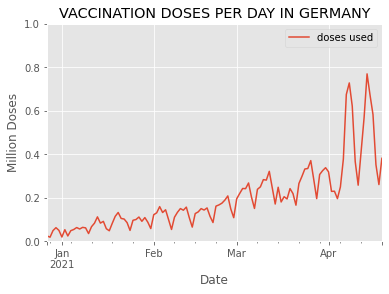

In [104]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily)),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Weekday (in the last 6 weeks)

In [105]:
last_6_weeks = doses.tail(42)

In [106]:
# Yields a warning, but exactly like the docs prescribe and it works
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()

<ipython-input-106-45013977109e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_6_weeks['weekday'] = last_6_weeks['date'].dt.day_name()


In [107]:
# check:
last_6_weeks.tail(3)

,date,doses used,weekday
111,2021-04-17,0.351720,Saturday
112,2021-04-18,0.260419,Sunday
113,2021-04-19,0.381095,Monday


In [108]:
# drop the date column
last_6_weeks = last_6_weeks.drop(labels=['date'], axis=1)

In [109]:
#last_6_weeks.set_index('weekday', inplace=True)
last_6_weeks.tail(3)

,doses used,weekday
111,0.351720,Saturday
112,0.260419,Sunday
113,0.381095,Monday


In [110]:
pivot_table =last_6_weeks.pivot(columns='weekday', values='doses used')
pivot_table.tail()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
109,NaN,NaN,NaN,NaN,0.672501,NaN,NaN
110,0.582685,NaN,NaN,NaN,NaN,NaN,NaN
111,NaN,NaN,0.35172,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,0.260419,NaN,NaN,NaN
113,NaN,0.381095,NaN,NaN,NaN,NaN,NaN


In [111]:
# Reorder the columns
pivot_table = pivot_table[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
# Rename the columns
pivot_table.columns=['Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_table.tail()

,Mo,Tue,Wed,Thu,Fri,Sat,Sun
109,NaN,NaN,NaN,0.672501,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,0.582685,NaN,NaN
111,NaN,NaN,NaN,NaN,NaN,0.35172,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,0.260419
113,0.381095,NaN,NaN,NaN,NaN,NaN,NaN


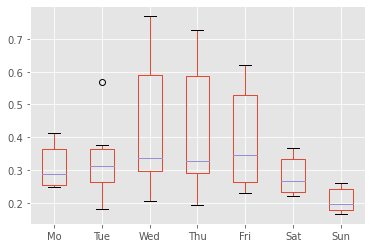

In [112]:
weekday_boxplot = pivot_table.boxplot()

In [113]:
fig = weekday_boxplot.get_figure()
fig.savefig('img/weekday_boxplot.png')

### Doses per Week

In [114]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.columns = ['million doses used']
doses_weekly.tail()

,million doses used
date,
2021-03-22,1.471186
2021-03-29,2.121477
2021-04-05,1.885878
2021-04-12,3.438902
2021-04-19,3.586421


In [115]:
# What is the highest number of doses used in a week?
max_million_doses_weekly = max(doses_weekly['million doses used'])
max_million_doses_weekly

3.586421

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY\n(until 2021-04-19)'}, xlabel='Date', ylabel='Million Doses'>

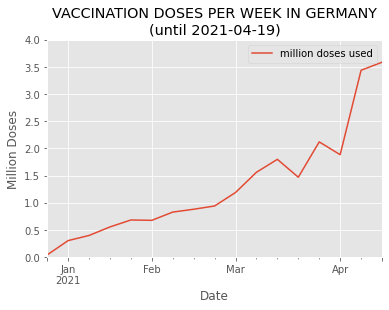

In [116]:
doses_weekly.plot(
    ylim=(0, math.ceil(max_million_doses_weekly)),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER WEEK IN GERMANY\n(until {last_update})")

### Doses per Month

In [117]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2020-12-31,0.203548
2021-01-31,2.342024
2021-02-28,3.771256
2021-03-31,7.813294
2021-04-30,8.248654


In [118]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
December 2020,0.203548
January 2021,2.342024
February 2021,3.771256
March 2021,7.813294
April 2021,8.248654


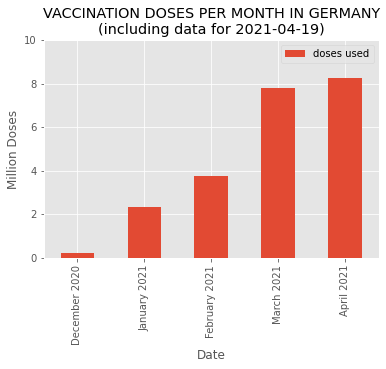

In [119]:
monthly_plot = doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly) + 1),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(including data for {last_update})")

In [120]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_germany.png')

## Vaccination Campaign Progress

In [121]:
doses_cumulative = vaccinations.loc[ : , ['date', 'personen_erst_kumulativ', 'personen_voll_kumulativ']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.tail(3)

,personen_erst_kumulativ,personen_voll_kumulativ
date,,
2021-04-17,16250463,5486799
2021-04-18,16472584,5525097
2021-04-19,16795784,5582992


In [122]:
population_germany = 83_200_000
# Calculate new fields
doses_cumulative['first vaccination'] = round(
    doses_cumulative['personen_erst_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative['fully vaccinated'] = round(
    doses_cumulative['personen_voll_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative.drop(columns=['personen_erst_kumulativ','personen_voll_kumulativ'], inplace=True)
doses_cumulative.tail(3)

,first vaccination,fully vaccinated
date,,
2021-04-17,19.53,6.59
2021-04-18,19.80,6.64
2021-04-19,20.19,6.71


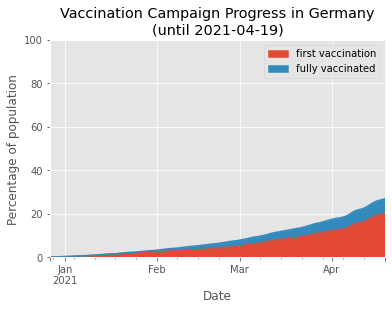

In [123]:
doses_area_plot = doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of population',
    title=f"Vaccination Campaign Progress in Germany\n(until {last_update})")

In [124]:
fig = doses_area_plot.get_figure()
fig.savefig('img/vaccinations_germany_area_plot.png')

### As of Today

In [125]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state


first vaccination    20.19
fully vaccinated      6.71
Name: 2021-04-19 00:00:00, dtype: float64

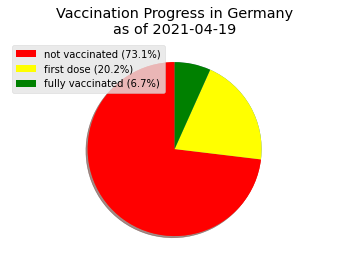

In [126]:
percentage_not_vacc = 100 - current_state['first vaccination'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['first vaccination'],1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'],1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['first vaccination'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress in Germany\nas of {last_update}")
plt.show()

## Vaccines in Use

In [127]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ',
                                     'dosen_moderna_kumulativ',
                                     'dosen_astrazeneca_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'Biontech', 'Moderna', 'AstraZeneca']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
# divide columns by 1 million
vaccine_use["Biontech"] = vaccine_use["Biontech"] / 1_000_000
vaccine_use["Moderna"] = vaccine_use["Moderna"] / 1_000_000
vaccine_use["AstraZeneca"] = vaccine_use["AstraZeneca"] / 1_000_000
vaccine_use.tail(3)

,Biontech,Moderna,AstraZeneca
date,,,
2021-04-17,16.081968,1.162570,4.492724
2021-04-18,16.249636,1.175525,4.572520
2021-04-19,16.526626,1.204361,4.647789


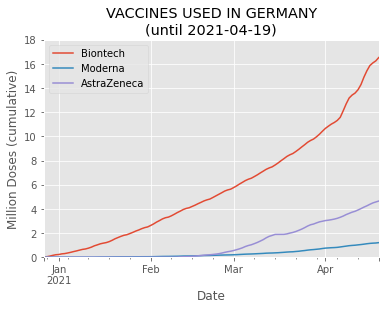

In [128]:
vaccines_used = vaccine_use.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0,math.ceil(max(vaccine_use.iloc[-1]))+1),
    xlabel='Date',
    ylabel='Million Doses (cumulative)',
    title=f"VACCINES USED IN GERMANY\n(until {last_update})")

In [129]:
fig = vaccines_used.get_figure()
fig.savefig('img/vaccines_used_in_germany.png')